In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

In [3]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Hyperparameters
latent_dim = 100
hidden_dim = 256
image_dim = 784
batch_size = 64
num_epochs = 100  # Increased epochs
lr = 0.0002

In [4]:
# Generator Network
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, image_dim),
            nn.Tanh()
        )
    
    def forward(self, z):
        return self.model(z)

# Discriminator Network
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(image_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

In [5]:
# Function to generate and save sample images
def save_samples(generator, fixed_noise, epoch, fig_size=(10, 10)):
    with torch.no_grad():
        fake_images = generator(fixed_noise)
        fake_images = fake_images.view(-1, 28, 28)
        
        plt.figure(figsize=fig_size)
        for i in range(16):
            plt.subplot(4, 4, i+1)
            plt.imshow(fake_images[i].cpu().numpy(), cmap='gray')
            plt.axis('off')
        plt.suptitle(f'Generated Images at Epoch {epoch}', fontsize=20)
        plt.tight_layout()
        return plt.gcf()

# Load MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist = torchvision.datasets.MNIST(root='./data', train=True, 
                                 transform=transform, download=True)
dataloader = DataLoader(mnist, batch_size=batch_size, shuffle=True)

In [6]:
# Initialize networks and optimizers
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator().to(device)
discriminator = Discriminator().to(device)
g_optimizer = optim.Adam(generator.parameters(), lr=lr)
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr)
criterion = nn.BCELoss()

# Fixed noise for visualization
fixed_noise = torch.randn(16, latent_dim,device=device)

# Training loop with visualization
d_losses = []
g_losses = []
evolution_images = []
checkpoints = [1, 10, 25, 50, 75, 100]  # Epochs to visualize

In [9]:
def train():
    for epoch in range(num_epochs):
        d_loss_epoch = 0
        g_loss_epoch = 0
        batch_count = 0
        
        for batch_idx, (real_images, _) in enumerate(dataloader):
            batch_size = real_images.size(0)
            real_images = real_images.view(batch_size, -1).to(device)
            
            # Train Discriminator
            discriminator.zero_grad()
            real_labels = torch.ones(batch_size, 1,device=device)
            fake_labels = torch.zeros(batch_size, 1,device=device)
            
            outputs = discriminator(real_images)
            d_loss_real = criterion(outputs, real_labels)
            
            z = torch.randn(batch_size, latent_dim,device=device)
            fake_images = generator(z)
            outputs = discriminator(fake_images.detach())
            d_loss_fake = criterion(outputs, fake_labels)
            
            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            d_optimizer.step()
            
            # Train Generator
            generator.zero_grad()
            outputs = discriminator(fake_images)
            g_loss = criterion(outputs, real_labels)
            g_loss.backward()
            g_optimizer.step()
            
            d_loss_epoch += d_loss.item()
            g_loss_epoch += g_loss.item()
            batch_count += 1

        d_losses.append(d_loss_epoch / batch_count)
        g_losses.append(g_loss_epoch / batch_count)
        
        if epoch % 10 ==0:
            print(f'Epoch [{epoch}/{num_epochs}], d_loss: {d_losses[-1]:.4f}, g_loss: {g_losses[-1]:.4f}')

In [10]:
# Train the model
train()

Epoch [1/100], d_loss: 0.3526, g_loss: 3.9608
Epoch [11/100], d_loss: 0.2786, g_loss: 4.8317
Epoch [21/100], d_loss: 0.3880, g_loss: 3.8510
Epoch [31/100], d_loss: 0.6333, g_loss: 2.5147
Epoch [41/100], d_loss: 0.6987, g_loss: 2.1711
Epoch [51/100], d_loss: 0.7696, g_loss: 2.0244
Epoch [61/100], d_loss: 0.8117, g_loss: 1.8785
Epoch [71/100], d_loss: 0.8643, g_loss: 1.7909
Epoch [81/100], d_loss: 0.8949, g_loss: 1.6889
Epoch [91/100], d_loss: 0.9197, g_loss: 1.6403


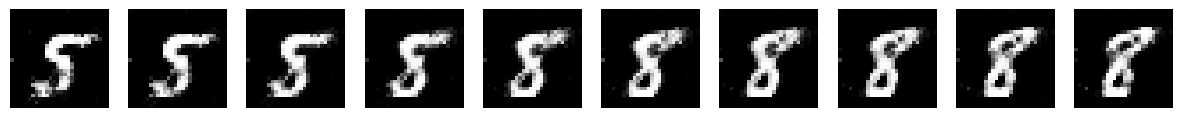

In [34]:
# Function for linear interpolation between two latent vectors
def interpolate_latent_space_gan(generator, start_z, end_z, num_steps=10):
    z_interpolated = [start_z * (1 - t) + end_z * t for t in np.linspace(0, 1, num_steps)]
    z_interpolated = torch.stack(z_interpolated).to(device)
    with torch.no_grad():
        generated_images = generator(z_interpolated).cpu()
    return generated_images

# Sample two random latent vectors from a normal distribution
z_dim = latent_dim  # Assume this is the dimension of the GAN's latent space
start_z = torch.randn(z_dim).to(device)
end_z = torch.randn(z_dim).to(device)

# Interpolate between the two vectors
num_steps = 10  # Number of steps for interpolation
generated_images = interpolate_latent_space_gan(generator, start_z, end_z, num_steps=num_steps)

# Visualization of interpolated images
fig, axes = plt.subplots(1, num_steps, figsize=(15, 2))
for i in range(num_steps):
    axes[i].imshow(generated_images[i].view(28, 28), cmap="gray")  # For MNIST, the image size is 28x28
    axes[i].axis("off")
plt.show()
